<a href="https://colab.research.google.com/github/mathewhall100/CHAMPS-molecular-properties/blob/master/CHAMPS(3)_deep_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAMPS molecular properties challenge - training and prediction using fastai deep learning model

## Introduction

In the notebook https://www.kaggle.com/mathewhall/champs-molecular-properties-eda I discuss an appraoch to the CHAMPS Molecular Predictions competition and carry out EDA on the provided datasets. The engineered data is then used to train and predict coupling constants, the prediction target, XGBoost and LightGBM machines and the result of the best model (LightGBM)  submitted to Kaggle (MAE 0.445 - 1697/2749 on the private leaderboard) https://www.kaggle.com/mathewhall/champs-molecular-properties-gb-models. 

The competition has now ended but I was interested to see if we could improve on this result by constructing a larger feature set and using a deep learning architecture. The initial datset consisted of features constructed from the competion datsets which described certain aspects of molecular geometry which are known from the NMR literature to primarily influence coupling constant magnitude (the prediction target) such as numbers (hybridisations) and lengths of chemical bonds involved in the couple and the angles associated with the 2j and 3j couples (cosine and dihedral). Examining the feature importances generated by the GBMs (https://www.kaggle.com/mathewhall/champs-molecular-properties-gb-models/edit) we see that the distance features were of greatest value. Furthermore since couling constants can be calculated from knowlege of the 3D geometry of atoms, it follows that adding features describing that geometry in more deatil might improve our model. This appraoch was taken by this kernal https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481 and here we adapt code from that notebook to add a larger set of distance features our data. 

We use a fastai tabular learner consisting of 5 hidden layers and catagorical embeddings for non-continuous features. Here we train and predict on subsets of the data divided by coupling type and recombine the results in the end to compare with our gradient boosting machines in the previous notebook. 

From the public notebooks and competition discussion boards it appears that combining comprehensive distance vectors, bond lengths and coupling angles into a single featureset as well as using the fastai library to construct a custom deep learning architecture are novel approaches to this challenge. 

## Library imports and notebok setup


In [0]:
# import all the other libraries we are going to need
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm_notebook as tqdm
from fastai import *
from fastai.tabular import *
from fastai.metrics import *

In [0]:
# Manage warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [0]:
# show complete dataframes
pd.set_option('display.max_columns', None) # display all dataframe columns
pd.set_option('display.max_rows', 120)

## Utils

In [0]:
# Initialise accumulator variables
preds_acc = None
preds_acc_type = None
val_scores = None

In [0]:
# Replace molecule_name with mol_index
def mol_name_to_index(df, cols):
    df['mol_index'] = df['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
    df = df[cols]
    return df

In [0]:
# Check dataframe mem usage
def check_mem_usage(df, print=False):
    if print: 
        print('Shape: ', train_df.shape)
        print('Total Mem usage: ', train_df.memory_usage().sum())
        print(train.memory_usage())
    return train_df.memory_usage().sum()

## Get data and briefly examine it
I have previously done a more thorough EDA at https://www.kaggle.com/mathewhall/champs-molecular-properties-eda

In [0]:
path = "../input/champs-scalar-coupling"
os.listdir(path)

['test.csv',
 'mulliken_charges.csv',
 'dipole_moments.csv',
 'train.csv',
 'structures.csv',
 'magnetic_shielding_tensors.csv',
 'potential_energy.csv',
 'sample_submission.csv',
 'scalar_coupling_contributions.csv',
 'structures']

We will only use three if the files provided:
1. train.csv - coded molecules names, index of coupling atoms, coupling type and constant
2. test.csv - same as test set but without coupling constants 
3. structures  - x,y cartesian co-ordinates of atom positions
note that the coupling constant (scalar_coupling_constant) is the label.

In [0]:
# Read train.csv and test.csv and load into dataframes
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_df = pd.read_csv(path+'/train.csv', index_col='id', dtype=train_dtypes)
test_df = pd.read_csv(path+'/test.csv', index_col='id', dtype=train_dtypes)

# create'molecule_id' col from' molecule_name' and drop 'molecule_name'
train_df = mol_name_to_index(train_df, ['mol_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant'])
test_df = mol_name_to_index(test_df, ['mol_index', 'atom_index_0', 'atom_index_1', 'type'])

print('Training set:')
display(train_df.head(5))
print('Test set:')
display(test_df.head(5))

Training set:


,mol_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404


Test set:


,mol_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC


In [0]:
# Briefly check the train and test datasets
train_unique_mols = train_df['mol_index'].nunique()
train_test_split = round(train_unique_mols/(train_unique_mols+test_df['mol_index'].nunique()), 2)

def ret_missing(df):
    return "None" if df.isnull().sum().sum() == 0 else df.isnull().sum()

def ret_num_type(df1, df2, type):
    num1 = len(df1[df1.type==type])
    num2 = len(df2[df2.type==type]) 
    pc1 = round(num1/(num1+num2), 2)
    pc2 = 1-num1
    return f'{num1} ({pc1})'


data = {'Shape':[train_df.shape, test_df.shape], 
        'Mem Usage':[train_df.memory_usage().sum(), test_df.memory_usage().sum()], 
        'split':[train_test_split, 1-train_test_split],
        'Rows':[train_df.shape[0], test_df.shape[0]], 
        'Unique molecules':[train_df["mol_index"].nunique(), test_df["mol_index"].nunique()], 
        'Missing values':[ret_missing(train_df), ret_missing(test_df)],
        'Unique coupling types':[train_df["type"].nunique(), test_df["type"].nunique()],
        '1JHC':[ret_num_type(train_df, test_df, '1JHC'), ret_num_type(test_df, train_df, '1JHC')],
        '1JHN':[ret_num_type(train_df, test_df, '1JHN'), ret_num_type(test_df, train_df, '1JHN')],
        '2JHH':[ret_num_type(train_df, test_df, '2JHH'), ret_num_type(test_df, train_df, '2JHH')],
        '2JHC':[ret_num_type(train_df, test_df, '2JHC'), ret_num_type(test_df, train_df, '2JHC')],
        '2JHN':[ret_num_type(train_df, test_df, '2JHN'), ret_num_type(test_df, train_df, '2JHN')],
        '3JHH':[ret_num_type(train_df, test_df, '3JHH'), ret_num_type(test_df, train_df, '3JHH')],
        '3JHC':[ret_num_type(train_df, test_df, '3JHC'), ret_num_type(test_df, train_df, '3JHC')],
        '3JHN':[ret_num_type(train_df, test_df, '3JHN'), ret_num_type(test_df, train_df, '3JHN')],
        }
pd.DataFrame(data, index=['Train', 'Test'])

,Shape,Mem Usage,split,Rows,Unique molecules,Missing values,Unique coupling types,1JHC,1JHN,2JHH,2JHC,2JHN,3JHH,3JHC,3JHN
Train,"(4658147, 5)",88505177,0.65,4658147,85003,None,8,709416 (0.65),43363 (0.64),378036 (0.65),1140674 (0.65),119253 (0.65),590611 (0.65),1510379 (0.65),166415 (0.65)
Test,"(2505542, 4)",37583514,0.35,2505542,45772,None,8,380609 (0.35),24195 (0.36),203126 (0.35),613138 (0.35),64424 (0.35),317435 (0.35),811999 (0.35),90616 (0.35)


In [0]:
# Read structures.csv and load into dataframe
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures = pd.read_csv(path+'/structures.csv', dtype=structures_dtypes)
structures = mol_name_to_index(structures, ['mol_index', 'atom_index', 'atom', 'x', 'y', 'z'])
structures['atom'] = structures['atom'].replace({'H':1, 'C':6,  'N':7,  'O':8,  'F':9})

print('Structures dataset:')
display(structures.tail(5))

Structures dataset:


,mol_index,atom_index,atom,x,y,z
2358652,133885,11,1,-1.454005,-0.967309,1.459246
2358653,133885,12,1,0.277779,-2.697872,0.195770
2358654,133885,13,1,2.515854,-1.151784,0.527369
2358655,133885,14,1,0.013699,1.199431,-1.680192
2358656,133885,15,1,1.260745,-1.246754,-1.906767


In [0]:
# Briefly check the structures dataset
atom_types = structures["atom"].unique()
print(f'STRUCTURES')
print(f'==========')
print(f'Shape: {structures.shape}'), 
print(f'Mem Usage: {structures.memory_usage().sum()}'),
print(f'Number rows: {structures.shape[0]}')
print(f'Unique molecules: {structures["mol_index"].nunique()}')
print(f'Unique atoms: {len(atom_types)} {atom_types}\n')
print(f'Check \'structures\' contains same number of molecules as \'train\' and \'test\'  combined: {"True" if structures["mol_index"].nunique()==train_df["mol_index"].nunique()+test_df["mol_index"].nunique() else "False"}')
print(f'Check for missing values: {"None" if structures.isnull().sum().sum() == 0 else structures.isnull().sum()}')

STRUCTURES
Shape: (2358657, 6)
Mem Usage: 58966553
Number rows: 2358657
Unique molecules: 130775
Unique atoms: 5 [6 1 7 8 9]

Check 'structures' contains same number of molecules as 'train' and 'test'  combined: True
Check for missing values: None


## Feature construction
See https://www.kaggle.com/mathewhall/champs-molecular-properties-eda for a more detailed description of feature construction and analysis.

Thank you to the following kernals and datasets for inspiration, data and code examples: https://www.kaggle.com/soerendip/angle-and-dihedral-for-the-champs-structures, https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481, https://www.kaggle.com/aekoch95/bonds-from-structure-data

## 1. Bond lengths

In [0]:
# Calculate chemical bonding of each atom (number bonds, index atom(s) bonded to and bond length(s))
# Code adapted from Aaron Koch, 'Recovering bonds from structure' public kernal
# Returns dataframe of bond data

def add_bonds(structures):
    # Add atomic radii for atoms t allow us to calculate bonds (atoms with very close or overlapping atomic radii are almost certainly bonded)
    atom_rad= {1:0.38, 6:0.77, 7:0.75, 8:0.73, 9:0.71}
    structures['rad'] = [atom_rad[x] for x in structures['atom'].values]
    
    bonding_margin= 0.05
    index_atom = structures['atom_index'].values
    p_comp = p = structures[['x','y','z']].values
    m_comp = m = structures['mol_index'].values
    r_comp = r = structures['rad'].values + bonding_margin

    src_row = np.arange(len(structures))
    max_atoms = 29
    bonds = np.zeros((len(structures)+1, max_atoms), dtype=np.int8)
    bond_dists = np.zeros((len(structures)+1, max_atoms), dtype=np.float32)
    
    for i in tqdm(range(max_atoms-1), desc="Calculating bonds: "):
        p_comp = np.roll(p_comp, -1, axis=0)
        m_comp = np.roll(m_comp, -1, axis=0)
        r_comp = np.roll(r_comp, -1, axis=0)

        mask = np.where(m == m_comp, 1, 0)
        dists = np.linalg.norm(p - p_comp, axis=1) * mask
    
        r_bond = r + r_comp
        bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)

        targ_row = src_row + i +1
        targ_row = np.where(np.logical_or(targ_row > len(structures), mask==0), len(structures), targ_row)

        src_atom = index_atom
        targ_atom = index_atom + i + 1
        targ_atom = np.where(np.logical_or(targ_atom > max_atoms-1, mask==0), max_atoms-1, targ_atom)

        bonds[(src_row, targ_atom)] = bond
        bonds[(targ_row, src_atom)] = bond
        bond_dists[(src_row, targ_atom)] = dists
        bond_dists[(targ_row, src_atom)] = dists

    bonds = np.delete(bonds, axis=0, obj=-1)
    bonds = np.delete(bonds, axis=1, obj=-1)
    bond_dists = np.delete(bond_dists, axis=0, obj=-1)
    bond_dists = np.delete(bond_dists, axis=1, obj=-1)
    
    print('Processing bond calculations...')
    bonds_to = [[i for i, x in enumerate(row) if x] for row in bonds]
    bond_lengths = [[dist for i, dist in enumerate(row) if i in bonds_to[j]] for j,row in enumerate(bond_dists)]
    n_bonds = [len(x) for x in bonds_to]
   
    print('Creating bonds dataframe...')
    bonds_df = pd.DataFrame({'num_bonds':n_bonds, 'bond_lengths':bond_lengths})
    bonds_df[['bond_len1', 'bond_len2', 'bond_len3', 'bond_len4']] = pd.DataFrame(bonds_df.bond_lengths.values.tolist())
    # bonds_df.fillna({'bond_len1':0, 'bond_len2':0, 'bond_len3':0, 'bond_len4':0}, inplace=True) # replace NaN's with 0's
    bonds_df.drop('bond_lengths', axis=1, inplace=True)
    
    # merge bonds data into structures dataframe
    if bonds.shape[0]== structures.shape[0]:  
        structures.drop({'rad'}, axis=1, inplace=True)
        return bonds_df
    else: 
        print('error: Incorrect number rows in bonds dataframe')
        
# Get bond calculations and add to structures df
bonds_df = add_bonds(structures)
print('Merging dataframes...')
structures = structures.join(bonds_df)
print('Done')
       


Processing bond calculations...
Creating bonds dataframe...
Merging dataframes...
Done


## 2. Cosine and dihedral angles for 2j and 3j couplings

In [0]:
# Add cosine and dihedral angles from file: https://www.kaggle.com/soerendip/angle-and-dihedral-for-the-champs-structures
def add_angles(df):
    angles = pd.read_csv("../input/angle-and-dihedral-for-the-champs-structures/angles.csv")
    mol_name_to_index(angles, ['mol_index', 'atom_index_0', 'atom_index_1', 'shortest_path_atoms', 'shortest_path_n_bonds', 'cosinus', 'dihedral'])

    # merge angles with base df
    df = pd.merge(df, angles, how='left',
                 left_on = ['mol_index', 'atom_index_0', 'atom_index_1'],
                 right_on = ['mol_index', 'atom_index_0', 'atom_index_1'])
    df.dropna(axis='columns', how='all')
    return df

## 3. Add distances

In [0]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner', on=['mol_index', 'atom_index_0', 'atom_index_1'])
    return df

In [0]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['mol_index'],
                  right_on=['mol_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [0]:
# Use the positional data on each couoled atoms to generate a featureset of distances between atoms
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [0]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [0]:
def add_n_atoms(base, structures):
    dfs = structures['mol_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='mol_index', right_index=True)

## Create training and test dataframes

In [0]:
def build_base_dataframe(base, structures, coupling_type, frac=False):
    if frac: 
        base = base.sample(frac=frac).drop('type', axis=1).copy()
    else: 
        base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['mol_index'].isin(base['mol_index'])]
    return base, structures

In [0]:
# Add the x,y,z co-ordinates from tructures to the base df
def add_structures(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['mol_index', f'atom_index_{index}'],
                  right_on=['mol_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [0]:
# Build the dataframe to be used in training. 
# Code adapted from https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481

def build_dataframe(df, structures_df, coupling_type, n_atoms=10, frac=False):
    
    # Construct the base df and add positional information from structures
    base, structures = build_base_dataframe(df, structures_df, coupling_type, frac)
    base = add_structures(base, structures, 0)
    base = add_structures(base, structures, 1)
    
    # drop redundant columns
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    # Create an atoms df to conatin distance features
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in df:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    # Add ditstance features to atoms df
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    atoms = merge_all_atoms(atoms, structures)
    add_distance_to_center(atoms)
    
    # Drop redundant columns from atoms df and group by molecule and atom index
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    
    # Sort and group by molecule and atom indexes
    atoms.sort_values(['mol_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['mol_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    # Reset the atoms index to keep in line with base df
    atoms = atoms.set_index(['mol_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # Downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['mol_index'] = atoms['mol_index'].astype('int32')
    
    # Combine the base and atoms dfs into a final df
    df_final = add_atoms(base, atoms)
    
    # Add the distance calculations to final df
    add_distances(df_final)
    
    # Add the angles features to final df
    df_final = add_angles(df_final)
    
    # Molecule name no longer needed as we have mol_index
    df_final.drop('molecule_name', axis=1, inplace=True)
    df_final.sort_values('id', inplace=True)
    
    return df_final

## Select coupling type and build featureset

In [0]:
# Select coupling type to predict from 1JHC, 1JHN, 2JHH, @JHC, 2JHN, 3JHH, 3JHC, 3JHN
# Pass 'frac' to select a fraction of the sample (e.g. frac=0.5 to select 50% of samples of that coupling type)

coupling_type='3JHN'
assert coupling_type in ['1JHC', '1JHN', '2JHH', '2JHC', '2JHN', '3JHH', '3JHC', '3JHN'], "Invalid coupling type"
fraction=False
if 'C' in coupling_type and fraction == False:
    fraction=0.5

print(f'Building features for coupling type: {coupling_type}...')    
train = build_dataframe(train_df, structures, coupling_type, n_atoms=8, frac=fraction)
test= build_dataframe(test_df, structures, coupling_type, n_atoms=8, frac=fraction)
current_coupling_type = coupling_type
print('Done')


Building features for coupling type: 3JHN...
Done


## Create databunch

In [0]:
print(f'Train set {train.shape}')
display(train.head())
print(f'Test set {test.shape}')
display(test.head())

Train set (166415, 161)


,id,mol_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,num_bonds_x,bond_len1_x,bond_len2_x,bond_len3_x,bond_len4_x,x_1,y_1,z_1,num_bonds_y,bond_len1_y,bond_len2_y,bond_len3_y,bond_len4_y,num_bonds_x_2,num_bonds_x_3,num_bonds_x_4,num_bonds_x_5,num_bonds_x_6,num_bonds_x_7,bond_len1_x_2,bond_len1_x_3,bond_len1_x_4,bond_len1_x_5,bond_len1_x_6,bond_len1_x_7,bond_len2_x_2,bond_len2_x_3,bond_len2_x_4,bond_len2_x_5,bond_len2_x_6,bond_len2_x_7,bond_len3_x_2,bond_len3_x_3,bond_len3_x_4,bond_len3_x_5,bond_len3_x_6,bond_len3_x_7,bond_len4_x_2,bond_len4_x_3,bond_len4_x_4,bond_len4_x_5,bond_len4_x_6,bond_len4_x_7,num_bonds_y_2,num_bonds_y_3,num_bonds_y_4,num_bonds_y_5,num_bonds_y_6,num_bonds_y_7,bond_len1_y_2,bond_len1_y_3,bond_len1_y_4,bond_len1_y_5,bond_len1_y_6,bond_len1_y_7,bond_len2_y_2,bond_len2_y_3,bond_len2_y_4,bond_len2_y_5,bond_len2_y_6,bond_len2_y_7,bond_len3_y_2,bond_len3_y_3,bond_len3_y_4,bond_len3_y_5,bond_len3_y_6,bond_len3_y_7,bond_len4_y_2,bond_len4_y_3,bond_len4_y_4,bond_len4_y_5,bond_len4_y_6,bond_len4_y_7,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,x_2,x_3,x_4,x_5,x_6,x_7,y_2,y_3,y_4,y_5,y_6,y_7,z_2,z_3,z_4,z_5,z_6,z_7,num_bonds_2,num_bonds_3,num_bonds_4,num_bonds_5,num_bonds_6,num_bonds_7,bond_len1_2,bond_len1_3,bond_len1_4,bond_len1_5,bond_len1_6,bond_len1_7,bond_len2_2,bond_len2_3,bond_len2_4,bond_len2_5,bond_len2_6,bond_len2_7,bond_len3_2,bond_len3_3,bond_len3_4,bond_len3_5,bond_len3_6,bond_len3_7,bond_len4_2,bond_len4_3,bond_len4_4,bond_len4_5,bond_len4_6,bond_len4_7,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,73,10,3,2,0.880802,1.002029,1.860899,0.002454,1,1.093317,NaN,NaN,NaN,0.017652,-1.144529,-0.004204,1,1.155009,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.093317,1.093317,1.093317,1.093317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.155009,1.155009,1.155009,1.155009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6,1,1,0,0,0.001738,-0.017886,-0.527078,-0.543988,NaN,NaN,0.010353,1.467128,1.835182,1.844799,NaN,NaN,0.002076,0.010113,0.904863,-0.870755,NaN,NaN,2.0,4.0,1.0,1.0,NaN,NaN,1.456930,1.456930,1.093306,1.093319,NaN,NaN,1.155009,1.093317,NaN,NaN,NaN,NaN,NaN,1.093319,NaN,NaN,NaN,NaN,NaN,1.093306,NaN,NaN,NaN,NaN,3.162537,2.103593,1.155009,1.093317,2.611938,1.456930,1.775718,3.162565,2.103491,1.093306,1.775647,3.162662,2.103532,1.093319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC,3,NaN,0.260329
1,78,10,4,2,0.880957,-0.543988,1.844799,-0.870755,1,1.093319,NaN,NaN,NaN,0.017652,-1.144529,-0.004204,1,1.155009,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.093319,1.093319,1.093319,1.093319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.155009,1.155009,1.155009,1.155009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6,1,1,0,0,0.001738,-0.017886,1.002029,-0.527078,NaN,NaN,0.010353,1.467128,1.860899,1.835182,NaN,NaN,0.002076,0.010113,0.002454,0.904863,NaN,NaN,2.0,4.0,1.0,1.0,NaN,NaN,1.456930,1.456930,1.093317,1.093306,NaN,NaN,1.155009,1.093317,NaN,NaN,NaN,NaN,NaN,1.093319,NaN,NaN,NaN,NaN,NaN,1.093306,NaN,NaN,NaN,NaN,3.162662,2.103531,1.155009,1.093319,2.611938,1.456930,1.775647,3.162537,2.103593,1.093317,1.775724,3.162565,2.103491,1.093306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC,3,NaN,2.354653
2,82,10,5,2,0.880871,-0.527078,1.835182,0.904863,1,1.093306,NaN,NaN,NaN,0.017652,-1.144529,-0.004204,1,1.155009,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.093306,1.093306,1.093306,1.093306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.155009,1.155009,1.155009,1.155009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6,1,1,0,0,0.001738,-0.017886,1.002029,-0.543988,NaN,NaN,0.010353,1.467128,1.860899,1.844799,NaN,NaN,0.0020

Test set (90616, 160)


,id,mol_index,atom_index_0,atom_index_1,x_0,y_0,z_0,num_bonds_x,bond_len1_x,bond_len2_x,bond_len3_x,bond_len4_x,x_1,y_1,z_1,num_bonds_y,bond_len1_y,bond_len2_y,bond_len3_y,bond_len4_y,num_bonds_x_2,num_bonds_x_3,num_bonds_x_4,num_bonds_x_5,num_bonds_x_6,num_bonds_x_7,bond_len1_x_2,bond_len1_x_3,bond_len1_x_4,bond_len1_x_5,bond_len1_x_6,bond_len1_x_7,bond_len2_x_2,bond_len2_x_3,bond_len2_x_4,bond_len2_x_5,bond_len2_x_6,bond_len2_x_7,bond_len3_x_2,bond_len3_x_3,bond_len3_x_4,bond_len3_x_5,bond_len3_x_6,bond_len3_x_7,bond_len4_x_2,bond_len4_x_3,bond_len4_x_4,bond_len4_x_5,bond_len4_x_6,bond_len4_x_7,num_bonds_y_2,num_bonds_y_3,num_bonds_y_4,num_bonds_y_5,num_bonds_y_6,num_bonds_y_7,bond_len1_y_2,bond_len1_y_3,bond_len1_y_4,bond_len1_y_5,bond_len1_y_6,bond_len1_y_7,bond_len2_y_2,bond_len2_y_3,bond_len2_y_4,bond_len2_y_5,bond_len2_y_6,bond_len2_y_7,bond_len3_y_2,bond_len3_y_3,bond_len3_y_4,bond_len3_y_5,bond_len3_y_6,bond_len3_y_7,bond_len4_y_2,bond_len4_y_3,bond_len4_y_4,bond_len4_y_5,bond_len4_y_6,bond_len4_y_7,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,x_2,x_3,x_4,x_5,x_6,x_7,y_2,y_3,y_4,y_5,y_6,y_7,z_2,z_3,z_4,z_5,z_6,z_7,num_bonds_2,num_bonds_3,num_bonds_4,num_bonds_5,num_bonds_6,num_bonds_7,bond_len1_2,bond_len1_3,bond_len1_4,bond_len1_5,bond_len1_6,bond_len1_7,bond_len2_2,bond_len2_3,bond_len2_4,bond_len2_5,bond_len2_6,bond_len2_7,bond_len3_2,bond_len3_3,bond_len3_4,bond_len3_5,bond_len3_6,bond_len3_7,bond_len4_2,bond_len4_3,bond_len4_4,bond_len4_5,bond_len4_6,bond_len4_7,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,4658205,20,4,2,0.807494,1.834551,0.321449,1,1.009036,NaN,NaN,NaN,1.219685,-0.623342,0.119632,3,1.388684,1.009039,1.008711,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.009036,1.009036,1.009036,1.009036,1.009036,1.009036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0,3.0,1.388684,1.388684,1.388684,1.388684,1.388684,1.388684,1.009039,1.009039,1.009039,1.009039,1.009039,1.009039,1.008711,1.008711,1.008711,1.008711,1.008711,1.008711,NaN,NaN,NaN,NaN,NaN,NaN,6,7,1,1,1,8,-0.025911,0.036053,1.999272,-0.858258,1.182043,-1.068229,-0.020766,1.360779,-0.173031,1.803735,-1.621479,-0.641746,0.002006,-0.124164,-0.336025,0.022438,-0.021092,0.008656,3.0,3.0,1.0,1.0,1.0,1.0,1.388677,1.388677,1.009039,1.008709,1.008711,1.213296,1.388684,1.009036,NaN,NaN,NaN,NaN,1.213296,1.008709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500374,2.058837,1.388684,1.009036,2.323178,1.388677,2.425488,1.009039,2.058839,2.500337,1.692657,3.196560,2.005497,1.008709,3.493103,1.008711,2.005485,3.196526,3.122215,2.290677,1.213296,2.290673,NC,3,NaN,-0.525919
1,4658209,20,5,2,-0.858258,1.803735,0.022438,1,1.008709,NaN,NaN,NaN,1.219685,-0.623342,0.119632,3,1.388684,1.009039,1.008711,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.008709,1.008709,1.008709,1.008709,1.008709,1.008709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0,3.0,1.388684,1.388684,1.388684,1.388684,1.388684,1.388684,1.009039,1.009039,1.009039,1.009039,1.009039,1.009039,1.008711,1.008711,1.008711,1.008711,1.008711,1.008711,NaN,NaN,NaN,NaN,NaN,NaN,6,7,1,8,1,1,-0.025911,0.036053,0.807494,-1.068229,1.999272,1.182043,-0.020766,1.360779,1.834551,-0.641746,-0.173031,-1.621479,0.002006,-0.124164,0.321449,0.008656,-0.336025,-0.021092,3.0,3.0,1.0,1.0,1.0,1.0,1.388677,1.388677,1.009036,1.213296,1.009039,1.008711,1.388684,1.009036,NaN,NaN,NaN,NaN,1.213296,1.008709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.196560,2.005497,1.388684,1.008709,2.323178,1.388677,1.692657,2.500374,2.058837,1.009036,2.454517,2.290677,1.213296,2.290673,3.493074,1.009039,2.058839,2.500337,3.987081,1.008711,2.005485,3.196526,NC,3,NaN,-2.891237
2,4658210,20,6,0,1.999272,-0.173031,-0.336025,1,1.009039,NaN,NaN,NaN,0.036053,1.360779,-0.124164,3,1.388677,1.009036,1.008709,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.009039,1.009039,1.009039,1.009039,1.0

In [0]:
# Remove columns with only one unique value
def drop_single_val_cols(df):
    for col in df.columns:
        if df[col].isnull().all():
            df.drop(col,inplace=True,axis=1)
        
drop_single_val_cols(train)
drop_single_val_cols(test)

print(f'Test set {train.shape}')
print(f'Test set {test.shape}')

Test set (166415, 139)
Test set (90616, 138)


In [0]:
# Remove uninformative data
train.drop(['id', 'shortest_path_n_bonds'], axis=1, inplace=True)
test.drop(['id', 'shortest_path_n_bonds'], axis=1, inplace=True)

In [0]:
# Fill missing values, create embeddings of catagorical data, normalise continuous data
procs = [FillMissing, Categorify, Normalize]

In [0]:
# 'Scalar coupling constant' is our dependent variable (target)
dep_var = 'scalar_coupling_constant'
# Catagorical data columns
cat_vars = ['mol_index', 'atom_index_0', 'atom_index_1', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7'] 
if 'shortest_path_atoms' in train.columns:
    cat_vars.append('shortest_path_atoms')
# Remainder are columns containing continous data
cont_vars = train.columns.tolist()
cont_vars.remove(dep_var)
cont_vars = [v for v in cont_vars if v not in (cat_vars)]

In [0]:
# Create databunch 
bs = 1024
path_out = "../input"
valid_idxs = range(round(len(train)-len(train)*0.2), len(train))
test_ = TabularList.from_df(test, path=path_out, cat_names=cat_vars, cont_names=cont_vars, procs=procs)

data = (TabularList.from_df(train, path=path_out, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                           .split_by_idx(valid_idxs)
                           .label_from_df(cols=dep_var, label_cls=FloatList, log=False) 
#                            .add_test(test_)
                           .databunch(bs=bs))
data.show_batch(rows=10)

mol_index,atom_index_0,atom_index_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,shortest_path_atoms,bond_len2_y_na,bond_len3_y_na,bond_len4_y_na,num_bonds_x_5_na,num_bonds_x_6_na,num_bonds_x_7_na,bond_len1_x_5_na,bond_len1_x_6_na,bond_len1_x_7_na,num_bonds_y_5_na,num_bonds_y_6_na,num_bonds_y_7_na,bond_len1_y_5_na,bond_len1_y_6_na,bond_len1_y_7_na,bond_len2_y_2_na,bond_len2_y_3_na,bond_len2_y_4_na,bond_len2_y_5_na,bond_len2_y_6_na,bond_len2_y_7_na,bond_len3_y_2_na,bond_len3_y_3_na,bond_len3_y_4_na,bond_len3_y_5_na,bond_len3_y_6_na,bond_len3_y_7_na,bond_len4_y_2_na,bond_len4_y_3_na,bond_len4_y_4_na,bond_len4_y_5_na,bond_len4_y_6_na,bond_len4_y_7_na,x_5_na,x_6_na,x_7_na,y_5_na,y_6_na,y_7_na,z_5_na,z_6_na,z_7_na,num_bonds_5_na,num_bonds_6_na,num_bonds_7_na,bond_len1_5_na,bond_len1_6_na,bond_len1_7_na,bond_len2_2_na,bond_len2_3_na,bond_len2_4_na,bond_len2_5_na,bond_len2_6_na,bond_len2_7_na,bond_len3_2_na,bond_len3_3_na,bond_len3_4_na,bond_len3_5_na,bond_len3_6_na,bond_len3_7_na,bond_len4_2_na,bond_len4_3_na,bond_len4_4_na,bond_len4_5_na,bond_len4_6_na,bond_len4_7_na,d_5_0_na,d_5_1_na,d_5_2_na,d_5_3_na,d_6_0_na,d_6_1_na,d_6_2_na,d_6_3_na,d_7_0_na,d_7_1_na,d_7_2_na,d_7_3_na,dihedral_na,x_0,y_0,z_0,num_bonds_x,bond_len1_x,x_1,y_1,z_1,num_bonds_y,bond_len1_y,bond_len2_y,bond_len3_y,bond_len4_y,num_bonds_x_2,num_bonds_x_3,num_bonds_x_4,num_bonds_x_5,num_bonds_x_6,num_bonds_x_7,bond_len1_x_2,bond_len1_x_3,bond_len1_x_4,bond_len1_x_5,bond_len1_x_6,bond_len1_x_7,num_bonds_y_2,num_bonds_y_3,num_bonds_y_4,num_bonds_y_5,num_bonds_y_6,num_bonds_y_7,bond_len1_y_2,bond_len1_y_3,bond_len1_y_4,bond_len1_y_5,bond_len1_y_6,bond_len1_y_7,bond_len2_y_2,bond_len2_y_3,bond_len2_y_4,bond_len2_y_5,bond_len2_y_6,bond_len2_y_7,bond_len3_y_2,bond_len3_y_3,bond_len3_y_4,bond_len3_y_5,bond_len3_y_6,bond_len3_y_7,bond_len4_y_2,bond_len4_y_3,bond_len4_y_4,bond_len4_y_5,bond_len4_y_6,bond_len4_y_7,x_2,x_3,x_4,x_5,x_6,x_7,y_2,y_3,y_4,y_5,y_6,y_7,z_2,z_3,z_4,z_5,z_6,z_7,num_bonds_2,num_bonds_3,num_bonds_4,num_bonds_5,num_bonds_6,num_bonds_7,bond_len1_2,bond_len1_3,bond_len1_4,bond_len1_5,bond_len1_6,bond_len1_7,bond_len2_2,bond_len2_3,bond_len2_4,bond_len2_5,bond_len2_6,bond_len2_7,bond_len3_2,bond_len3_3,bond_len3_4,bond_len3_5,bond_len3_6,bond_len3_7,bond_len4_2,bond_len4_3,bond_len4_4,bond_len4_5,bond_len4_6,bond_len4_7,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,dihedral,target
83776,14,1,6,6,1,6,1,1,CC,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,True,False,True,True,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,-1.1171,-0.9065,-0.4822,0.0000,0.3487,-0.1101,0.2040,-0.0283,0.5886,0.4495,0.8652,1.4646,0.0205,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3487,0.3487,0.3487,0.3487,0.3487,0.3487,0.5886,0.5886,0.5886,0.5886,0.5885,0.5884,0.4495,0.4495,0.4495,0.4495,0.4495,0.4494,0.8652,0.8652,0.8652,0.8652,0.8651,0.8651,1.4646,1.4646,1.4646,1.4646,1.4646,1.4646,0.0205,0.0205,0.0205,0.0205,0.0205,0.0205,-1.0628,-1.1502,-1.4380,-0.2059,0.1621,-1.5640,-0.0757,-0.9917,0.1900,-1.3003,-1.3197,-1.0985,0.6118,0.2419,0.2874,0.4011,-0.3008,0.7331,0.7559,0.4863,-0.8608,1.3112,-1.0109,-0.9985,0.4953,0.5382,-0.8092,1.3559,-1.0094,-0.9614,0.7638,0.9557,0.2345,0.8208,0.2233,0.2402,1.1828,-0.5846,0.2577,-1.7707,0.2074,-0.2859,-0.4709,-0.1808,-0.2089,-0.1852,-0.1856,-0.1672,-0.7655,0.5413,-0.1733,-0.5381,0.4139,0.1256,0.5019,0.0481,-1.6293,0.3688,-0.5846,0.5573,0.9957,-0.6432,-0.6027,0.4384,1.6710,-0.0245,-1.6979,1.0989,-0.1164,-1.6815,-0.6436,0.783443
36636,15,5,6,7,6,8,6,1,NC,False,True,True,False,False,False,False,False,False,False,False,False,False,False,Fa

## Model

In [0]:
# Define MAE metric
def mae_custom(pred:Tensor, targ:Tensor)->Rank0Tensor:
    pred, targ = flatten_check(pred,targ)
    return F.l1_loss(pred, targ)

In [0]:
# Create Model
learn = tabular_learner(data, layers=[4096, 2048, 1024, 512, 256], ps=[0.001, 0.001, 0.01, 0.01, 0.01], emb_drop=0.04, metrics=[mae_custom, rmse])
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(37623, 584)
    (1): Embedding(26, 10)
    (2): Embedding(13, 7)
    (3): Embedding(5, 4)
    (4): Embedding(5, 4)
    (5): Embedding(6, 4)
    (6): Embedding(7, 5)
    (7): Embedding(7, 5)
    (8): Embedding(7, 5)
    (9): Embedding(11, 6)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
    (21): Embedding(3, 3)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
    (26): Embedding(3, 3)
    (27): Embedding(3, 3)
    (28): Embedding(3, 3)
    (29): Embedding(3, 3)
    (30): Embedding(3, 3)
    (31): Embedding(3, 3)
    (32): Embedding(3, 3)
    (33): Embedding(3, 3)
    (34): Embedding(3, 3)
    (35): Embedding(3, 3)
    (36): Embedding(3, 3)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


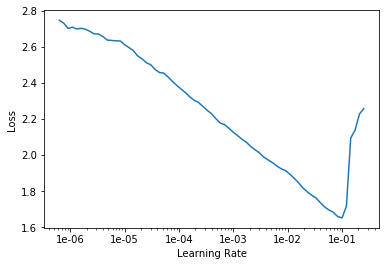

In [0]:
# Find optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [0]:
# Select optimal learning rate and train model
learn.fit_one_cycle(20, 2e-2)

epoch,train_loss,valid_loss,mae_custom,root_mean_squared_error,time
0,0.604142,0.481057,0.496641,0.685800,00:19
1,0.347013,0.360884,0.409465,0.596922,00:20
2,0.276418,0.287140,0.387959,0.531400,00:19
3,0.216405,0.262534,0.353602,0.507273,00:19
4,0.191150,0.233033,0.331105,0.477236,00:18
5,0.160922,0.211958,0.310820,0.456920,00:19
6,0.128551,0.350908,0.394770,0.586506,00:19
7,0.106347,0.209043,0.298315,0.451136,00:18
8,0.100099,0.220388,0.324177,0.464445,00:20
9,0.074669,0.185727,0.278819,0.425892,00:19


## Predictions

In [0]:
# Make predictions 
from sklearn.metrics import mean_absolute_error

val_preds = learn.get_preds(DatasetType.Valid)
y = train.iloc[valid_idxs].scalar_coupling_constant
y_preds = val_preds[0][:,0].numpy()

mae_current = np.log(mean_absolute_error(y, y_preds))
print(f'Mean absolute error {current_coupling_type} coupling type: {mae_current}')

Mean absolute error 3JHN coupling type: -1.4129091501235962


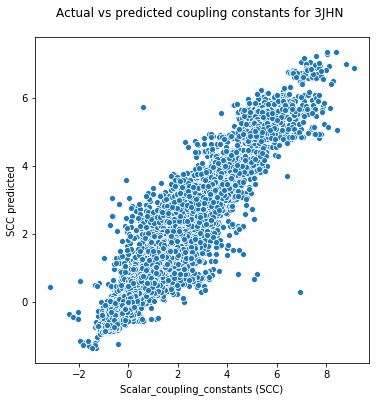

In [0]:
# Plot predicted vs actual results for currently calculated coupling type
import matplotlib.pyplot as plt
   
plt.figure(figsize=(6,6))
scatterplt = sns.scatterplot(x=y, y=y_preds)
scatterplt.set(xlabel='Scalar_coupling_constants (SCC)', ylabel='SCC predicted')
plt.title(f'Actual vs predicted coupling constants for {current_coupling_type} ', pad=20)
plt.show()
    

## Accumulate results 

In [0]:
## Aggregate predictions from individual coupling types
if preds_acc is None:
    preds_acc = []
preds_acc = preds_acc + list(zip(y, y_preds))

if preds_acc_type is None:
    preds_acc_type = {}
preds_acc_type[(f'{current_coupling_type}')] = list(zip(y, y_preds))

if val_scores is None: 
    val_scores = {}
val_scores[current_coupling_type] =  mae_current


## Visualize

Mean absolute error agregate: -0.4679783485325831


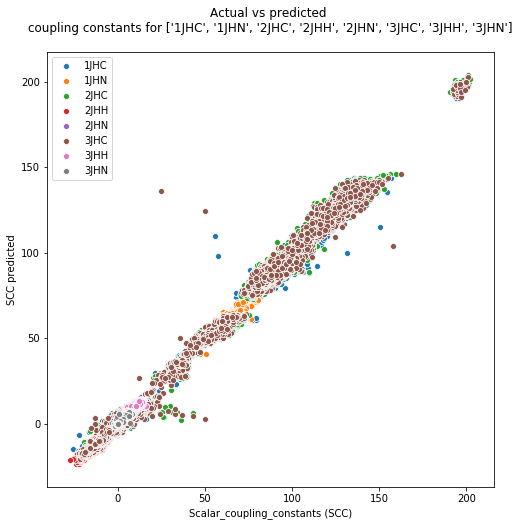

In [0]:
# Calculate aggregate MAE and plot
acc = list(zip(*preds_acc))
 
print(f'Mean absolute error agregate: {np.log(mean_absolute_error(acc[0], acc[1]))}')

plt.figure(figsize=(8,8))
p = [0,0]
k = [0,0]
for i in range(len(preds_acc_type)):
    p[0]= list(preds_acc_type.values())
    k[0] = list(preds_acc_type.keys())
    p_ = list(zip(*p[0][i]))
    
    ax = scatterplt = sns.scatterplot(x=p_[0], y=p_[1], label=str(k[0][i]))
    scatterplt.set(xlabel='Scalar_coupling_constants (SCC)', ylabel='SCC predicted')
    plt.title(f'Actual vs predicted \ncoupling constants for {k[0]}', pad=20)

ax.legend()    
plt.show()

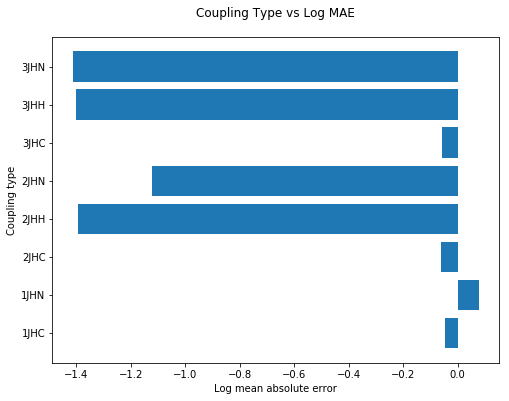

In [0]:
# Plot results by type
type_score = {}
plt.figure(figsize=(8, 6))
plt.barh(list(val_scores.keys()), list(val_scores.values()))
plt.xlabel('Log mean absolute error')
plt.ylabel('Coupling type')
plt.title('Coupling Type vs Log MAE', pad=20)
plt.show()

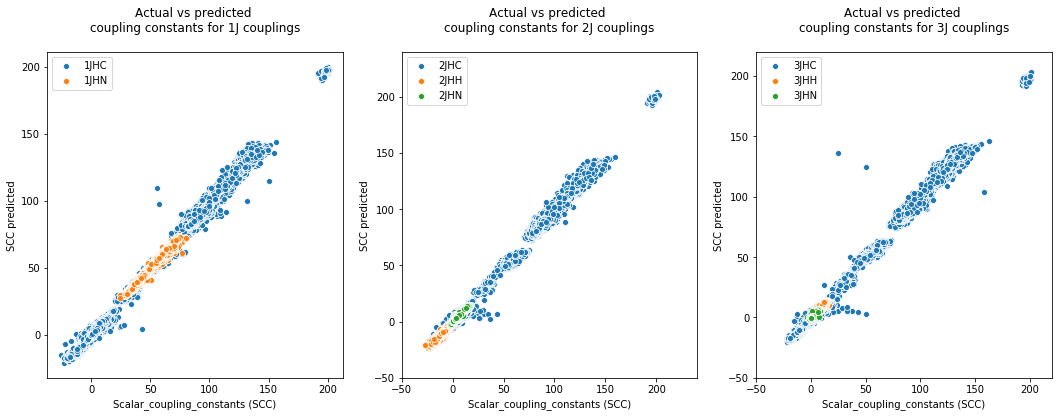

In [0]:
# Loop through preds_acc_type and plot individual coupling type graphs
num_plots = len(preds_acc_type)
fig, ax = plt.subplots(figsize=(6*3, 6))

for i in range(len(preds_acc_type)):
    p[0]= list(preds_acc_type.values())
    k[0] = list(preds_acc_type.keys())
    p_ = list(zip(*p[0][i]))
    
    plt.subplot(1,3,1)
    if str(k[0][i]) == '1JHC': scatterplt = sns.scatterplot(x=p_[0], y=p_[1], label=str(k[0][i]))
    if str(k[0][i]) == '1JHN': scatterplt = sns.scatterplot(x=p_[0], y=p_[1], label=str(k[0][i]))
    scatterplt.set(xlabel='Scalar_coupling_constants (SCC)', ylabel='SCC predicted')
    plt.title(f'Actual vs predicted \ncoupling constants for 1J couplings', pad=20)
    
    plt.subplot(1,3,2)
    if str(k[0][i]) == '2JHC': scatterplt = sns.scatterplot(x=p_[0], y=p_[1], label=str(k[0][i]))
    if str(k[0][i]) == '2JHH': scatterplt = sns.scatterplot(x=p_[0], y=p_[1], label=str(k[0][i]))
    if str(k[0][i]) == '2JHN': scatterplt = sns.scatterplot(x=p_[0], y=p_[1], label=str(k[0][i]))
    scatterplt.set(xlabel='Scalar_coupling_constants (SCC)', ylabel='SCC predicted')
    plt.xlim(-50, 240)
    plt.ylim(-50, 240)
    plt.title(f'Actual vs predicted \ncoupling constants for 2J couplings', pad=20)
    
    plt.subplot(1,3,3)
    if str(k[0][i]) == '3JHC': scatterplt = sns.scatterplot(x=p_[0], y=p_[1], label=str(k[0][i]))
    if str(k[0][i]) == '3JHH': scatterplt = sns.scatterplot(x=p_[0], y=p_[1], label=str(k[0][i]))
    if str(k[0][i]) == '3JHN': scatterplt = sns.scatterplot(x=p_[0], y=p_[1], label=str(k[0][i]))
    scatterplt.set(xlabel='Scalar_coupling_constants (SCC)', ylabel='SCC predicted')
    plt.xlim(-50, 220)
    plt.ylim(-50, 220)
    plt.title(f'Actual vs predicted \ncoupling constants for 3J couplings', pad=20)

plt.show()


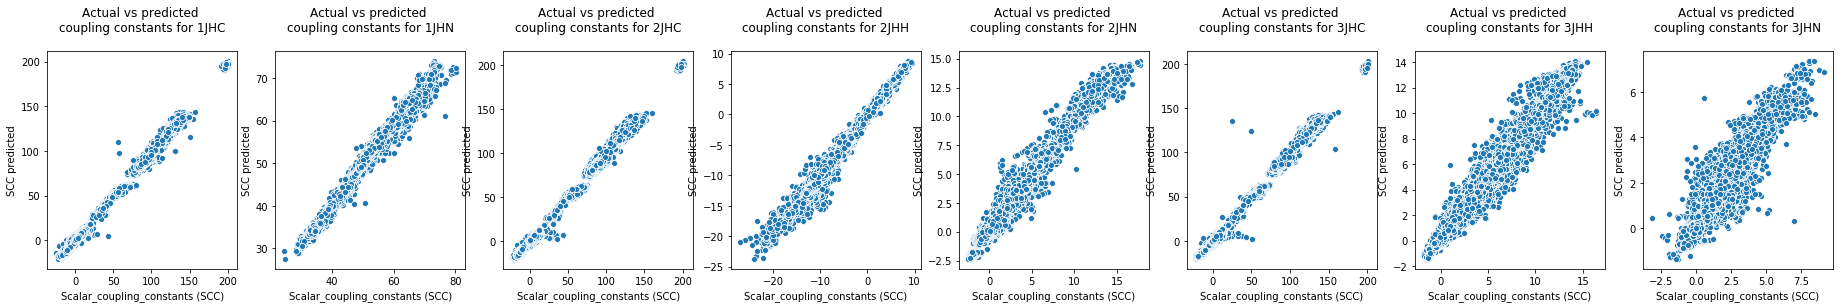

In [0]:
# Loop through preds_acc_type and plot individual coupling type graphs
num_plots = len(preds_acc_type)
fig, ax = plt.subplots(figsize=(4*num_plots, 4))

for i in range(len(preds_acc_type)):
    p[0]= list(preds_acc_type.values())
    k[0] = list(preds_acc_type.keys())
    p_ = list(zip(*p[0][i]))
    
    plt.subplot(1,num_plots,i+1)
    scatterplt = sns.scatterplot(x=p_[0], y=p_[1],)
    scatterplt.set(xlabel='Scalar_coupling_constants (SCC)', ylabel='SCC predicted')
    plt.title(f'Actual vs predicted \ncoupling constants for {k[0][i]}', pad=20)
    
plt.show()


## Save model

In [0]:
file = f'/nn_model_{current_coupling_type}'
learn.save(path_out+file)

##### Conclusion

We have constrcuted a rich set of features describing the binding and geometries around the coupling atoms and have used a 5 hidden layer deep learning network to train and predict scalar coupling constants for this data.

Following the strategy employed that guave best results with the GBM model (https://www.kaggle.com/mathewhall/champs-molecular-properties-gb-models), we divide the data by coupling type and successfully used it train and predict on each coupling type separately. Due to GPU memory constraints we also had to reduce the size of the larger subsets (noteably the JHC couplings) for training and prediction. 

With this methodology an log MAE of 0.46 was achieved in predictions on a validation set. This is slightly better than our GBM model (0.44). 

Further optinization of the dataset and deep learning architecture employed will likely lead to further improvements. 

